### Importing required libraries

In [32]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, MaxPool2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
import os
import matplotlib.pyplot as plt
import glob
import cv2
import seaborn as sns
from tensorflow.keras import regularizers

In [ ]:
TRAIN_PATH = "D:\IIT\Subjects\(4606)Machine Vision\CW\Develo\DataSet\Classification\Training"
VAL_PATH = "D:\IIT\Subjects\(4606)Machine Vision\CW\Develo\DataSet\Classification\Validation"
TEST_PATH = "D:\IIT\Subjects\(4606)Machine Vision\CW\Develo\DataSet\Classification\Testing"

### Initializing Image Size

In [34]:
IMAGE_SIZE = (128, 128)

### Initializing train, validation & test data

In [35]:
import tensorflow as tf

# Load datasets
training_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=None,
    subset=None,
    shuffle=True,
    batch_size=32,
    image_size=IMAGE_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_PATH,
    validation_split=None,
    subset=None,
    shuffle=True,
    batch_size=32,
    image_size=IMAGE_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_PATH,
    validation_split=None,
    subset=None,
    shuffle=False,
    batch_size=32,
    image_size=IMAGE_SIZE
)


Found 4571 files belonging to 4 classes.
Found 1141 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


### Plot Images with labels

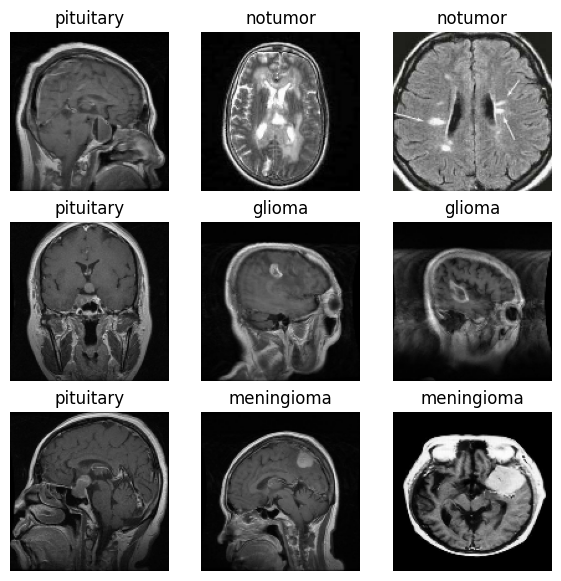

In [36]:
plt.figure(figsize=(7, 7))
for images, labels in training_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(training_ds.class_names[labels[i]])
        plt.axis("off")

In [37]:
class_num = 4
input_shape = (128,128,3)

### Import model for Transfer Learning

In [38]:
efficientnet = tf.keras.applications.efficientnet.EfficientNetB1(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape,
    pooling="avg",
    classes=class_num
)

In [39]:
efficientnet.summary() 

Model: "efficientnetb1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 128, 128,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 128, 128,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 128, 128,  │          0 │ normalization_2[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │        512 │ block1a_se_excit

 Total params: 6,575,239 (25.08 MB)

 Trainable params: 6,513,184 (24.85 MB)

 Non-trainable params: 62,055 (242.41 KB)

### Freeze layerns in EfficientNetB1

In [40]:
for layer in efficientnet.layers[:-5]:
    layer.trainable = False

In [41]:
for layer in efficientnet.layers:
    print(layer.name, layer.trainable)

input_layer_2 False
rescaling_4 False
normalization_2 False
rescaling_5 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block1b_dwconv False
block1b_bn False
block1b_activation False
block1b_se_squeeze False
block1b_se_reshape False
block1b_se_reduce False
block1b_se_expand False
block1b_se_excite False
block1b_project_conv False
block1b_project_bn False
block1b_drop False
block1b_add False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn F

### Building the classification model

In [42]:
inputs = tf.keras.Input(shape=input_shape, name='image_input')

x = tf.keras.applications.efficientnet.preprocess_input(inputs)
x = efficientnet(x)
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(.3)(x)
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(.3)(x)
x = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(.3)(x)
outputs = Dense(class_num, activation='softmax')(x)

effnet_model = tf.keras.Model(inputs, outputs, name='output')

### Compile the model

In [43]:
effnet_model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [44]:
from tensorflow.keras.utils import plot_model

plot_model(effnet_model, to_file='model_eff.png',show_shapes=True, show_layer_names=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


### Train the model

In [45]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)
#mc =  ModelCheckpoint('EfficientNet_classification.h5', monitor='val_loss', verbose=1, save_best_only=True)
mc = ModelCheckpoint('EfficientNet_classification.keras', monitor='val_loss', verbose=1, save_best_only=True)


history_effnet = effnet_model.fit(training_ds, validation_data = val_ds,
          epochs = 30, batch_size = 32, callbacks = [es, mc])


Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.5540 - loss: 6.1353
Epoch 1: val_loss improved from inf to 2.05061, saving model to EfficientNet_classification.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 402ms/step - accuracy: 0.5550 - loss: 6.1232 - val_accuracy: 0.8501 - val_loss: 2.0506
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.8437 - loss: 1.7157
Epoch 2: val_loss improved from 2.05061 to 0.96147, saving model to EfficientNet_classification.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 46s 322ms/step - accuracy: 0.8438 - loss: 1.7138 - val_accuracy: 0.8931 - val_loss: 0.9615
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.8846 - loss: 0.9253
Epoch 3: val_loss improved from 0.96147 to 0.64440, saving model to EfficientNet_classification.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 47s 328ms/step - accuracy: 0.8847 - loss: 0.9247 - val_accuracy: 0.9150 - val_loss: 0.6444
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.9094 -

### Train, Validation & Test accuracy from saved model

In [46]:
from keras.models import load_model
saved_model = load_model('EfficientNet_classification.keras')

train_loss, train_acc = saved_model.evaluate(training_ds, verbose=0)
val_loss, val_acc = saved_model.evaluate(val_ds, verbose=0)
test_loss, test_acc = saved_model.evaluate(test_ds, verbose=0)


print(f'Accuracy and loss of the best model : ')
print(f'Train accuracy: {train_acc*100:.3f} % || Validation accuracy: {val_acc*100:.3f} % || Test accuracy: {test_acc*100:.3f} %')
print(f'Train loss: {train_loss:.3f} || Validation loss: {val_loss:.3f} || Test loss: {test_loss:.3f}')

Accuracy and loss of the best model : 
Train accuracy: 99.716 % || Validation accuracy: 95.968 % || Test accuracy: 96.034 %
Train loss: 0.169 || Validation loss: 0.287 || Test loss: 0.273


### Plot Accuracy & Loss graphs

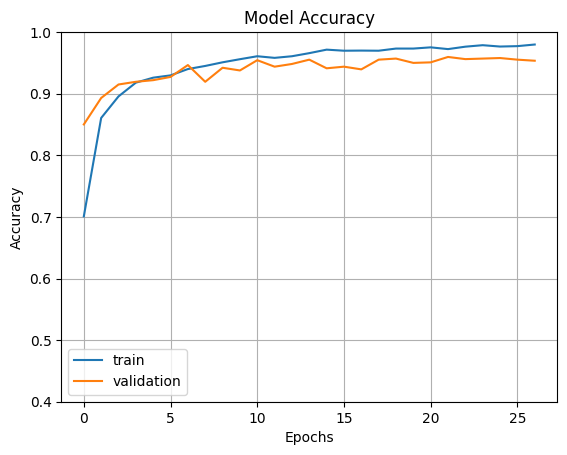

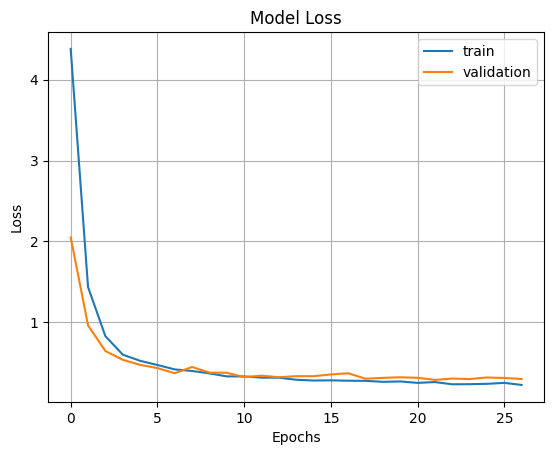

In [47]:
fig1 = plt.gcf()
plt.plot(history_effnet.history['accuracy'])
plt.plot(history_effnet.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


plt.plot(history_effnet.history['loss'])
plt.plot(history_effnet.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

### Predictions on Test data

In [48]:
prediction_effnet = saved_model.predict(test_ds) 
prediction_effnet=np.argmax(prediction_effnet,axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 323ms/step


In [49]:
true_labels = []  

for image_batch, label_batch in test_ds:
    true_labels.append(label_batch)
    
correct_labels = tf.concat([item for item in true_labels], axis = 0)
correct_labels = correct_labels.numpy()

In [50]:
print(type(prediction_effnet))
print(type(correct_labels))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### F1- Score, Precision & Recall

In [51]:
from sklearn.metrics import classification_report

print(classification_report(correct_labels, prediction_effnet))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       300
           1       0.94      0.91      0.92       306
           2       0.99      1.00      0.99       405
           3       0.97      0.97      0.97       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



### Confusion Matrix

<Axes: >

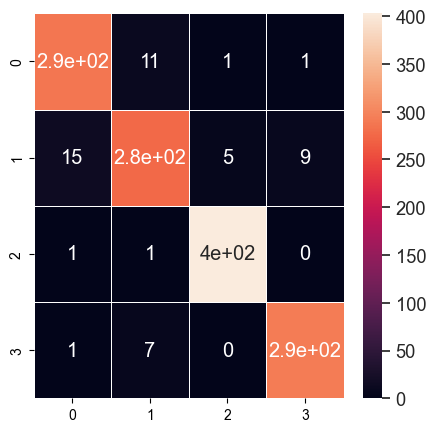

In [52]:
cm = confusion_matrix(correct_labels, prediction_effnet)

fig, ax = plt.subplots(figsize=(5,5))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)